# Edward Leardi

# Metis Project #2

# Using Linear Regression with Ratemyprofessors.com Data

# Part #3: Regression Modeling

&nbsp;

In [99]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://cdn1.theodysseyonline.com/files/2016/02/23/6359184783982034321887056811_RateMyProfessors-logo.png")

## Table of Contents

1. Import the data
2. Clean up the data
3. Examine & Explore the data
4. Baseline OLS Model (1 feature)
5. Expanded OLS Model (7 features)
6. Full OLS Model (21 features) 
7. Cross Validation on OLS
8. Cross Validation on LASSO, Ridge, EN & Testing Alphas
9. Apply on test data


In [40]:
import pandas as pd
import numpy as np
import csv

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import (cross_val_score, train_test_split, KFold, GridSearchCV)
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import preprocessing

import scipy.stats as stats

## 1. Loading in the Data

* Load in the data from 50+ csv files generated by Beautiful Soup

In [41]:
def get_RMP_data(file_nums):
    generic_file_name = "output{}.csv"
    dfs = []
    for file_num in file_nums:
        file_name = generic_file_name.format(file_num)
        if file_name == "output5.csv":
            dfs.append(pd.read_csv(file_name))
        else:
            # Only first csv file has a header row, appending same header to all other csvs as they're read in
            dfs.append(pd.read_csv(file_name, names = ["ID",
                                                        "URL",
                                                        "Full_Name",
                                                        "School",
                                                        "Num_of_Ratings",
                                                        "Overall_Rating",
                                                        "Take_Again",
                                                        "Difficulty",
                                                        "Hotness",
                                                        "TOUGH_GRADER",
                                                        "GIVES_GOOD_FEEDBACK",
                                                        "RESPECTED",
                                                        "GET_READY_TO_READ",
                                                        "PARTICIPATION_MATTERS",
                                                        "SKIP_CLASS_YOU_WONT_PASS",
                                                        "LOTS_OF_HOMEWORK",
                                                        "INSPIRATIONAL",
                                                        "BEWARE_OF_POP_QUIZZES",
                                                        "ACCESSIBLE_OUTSIDE_CLASS",
                                                        "SO_MANY_PAPERS",
                                                        "CLEAR_GRADING_CRITERIA",
                                                        "HILARIOUS",
                                                        "TEST_HEAVY",
                                                        "GRADED_BY_FEW_THINGS",
                                                        "AMAZING_LECTURES",
                                                        "CARING",
                                                        "EXTRA_CREDIT",
                                                        "GROUP_PROJECTS",
                                                        "LECTURE_HEAVY"
                                                          ]))
    return pd.concat(dfs)

def get_file_nums(num_of_files):
    file_nums = []
    # First few file nums were tests and thus a bit out of order
    file_nums.extend([5,10,15,20,30])
    for x in range(1,num_of_files+1):
        num_of_file = (x * 20) + 20
        file_nums.append(num_of_file)
    return file_nums

file_nums = get_file_nums(85)
RMP_df = get_RMP_data(file_nums)


In [42]:
RMP_df.head()
# Num_of_Ratings = Target
# All columns right of Target are features
# All columns left of Target are identifiers/extras

,ID,URL,Full_Name,School,Num_of_Ratings,Overall_Rating,Take_Again,Difficulty,Hotness,TOUGH_GRADER,...,SO_MANY_PAPERS,CLEAR_GRADING_CRITERIA,HILARIOUS,TEST_HEAVY,GRADED_BY_FEW_THINGS,AMAZING_LECTURES,CARING,EXTRA_CREDIT,GROUP_PROJECTS,LECTURE_HEAVY
0,0,http://www.ratemyprofessors.com/ShowRatings.js...,Richard Beck,Abilene Christian University,63,4.8,100%,2.1,1,0,...,0,0,19,3,0,15,0,10,0,1
1,1,http://www.ratemyprofessors.com/ShowRatings.js...,Mark Cullum,Abilene Christian University,44,3.2,80%,3.7,0,5,...,0,1,1,1,0,0,1,0,0,4
2,2,http://www.ratemyprofessors.com/ShowRatings.js...,Steven Moore,Abilene Christian University,40,4.7,100%,2.6,1,0,...,0,0,2,0,0,4,4,0,0,0
3,3,http://www.ratemyprofessors.com/ShowRatings.js...,Anthony Ash,Abilene Christian University,40,4,NaN,2.3,NaN,0,...,0,0,1,0,0,0,0,0,0,3
4,4,http://www.ratemyprofessors.com/ShowRatings.js...,Jerry Taylor,Abilene Christian University,38,3.8,67%,1.8,0,0,...,0,1,5,0,1,4,0,0,12,5


In [43]:
RMP_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74855 entries, 0 to 693
Data columns (total 29 columns):
ID                          74855 non-null int64
URL                         74855 non-null object
Full_Name                   74855 non-null object
School                      74855 non-null object
Num_of_Ratings              74855 non-null object
Overall_Rating              74855 non-null object
Take_Again                  17847 non-null object
Difficulty                  74855 non-null object
Hotness                     70587 non-null object
TOUGH_GRADER                74855 non-null object
GIVES_GOOD_FEEDBACK         74855 non-null object
RESPECTED                   74855 non-null object
GET_READY_TO_READ           74855 non-null object
PARTICIPATION_MATTERS       74855 non-null object
SKIP_CLASS_YOU_WONT_PASS    74855 non-null object
LOTS_OF_HOMEWORK            74855 non-null object
INSPIRATIONAL               74855 non-null object
BEWARE_OF_POP_QUIZZES       74855 non-null o

## 2. Cleaning up the Data
* Remove certain columns
* Convert features to correct data type
* Correct for NaN and errors
* Remove outliers using Num of Ratings column 
* Also tried target variable log transform and feature standardization, code not included here though

In [44]:
# Drop Take_Again column, missing 60,000 values
RMP_df = RMP_df.drop(["Take_Again"], axis=1)

In [45]:
# Delete rows where Hotness=np.nan
RMP_df = RMP_df[pd.notnull(RMP_df["Hotness"])]

# Delete rows where tags=error (only deletes 2 because most that had errors, also had NaN in Hotness column)
error_mask = ((RMP_df["Difficulty"] != "error") &
                (RMP_df["TOUGH_GRADER"] != "error") &
                (RMP_df["GIVES_GOOD_FEEDBACK"] != "error") &
                (RMP_df["RESPECTED"] != "error") &
                (RMP_df["GET_READY_TO_READ"] != "error") &
                (RMP_df["PARTICIPATION_MATTERS"] != "error") &
                (RMP_df["SKIP_CLASS_YOU_WONT_PASS"] != "error") &
                (RMP_df["LOTS_OF_HOMEWORK"] != "error") &
                (RMP_df["INSPIRATIONAL"] != "error") &
                (RMP_df["BEWARE_OF_POP_QUIZZES"] != "error") &
                (RMP_df["ACCESSIBLE_OUTSIDE_CLASS"] != "error") &
                (RMP_df["SO_MANY_PAPERS"] != "error") &
                (RMP_df["CLEAR_GRADING_CRITERIA"] != "error") &
                (RMP_df["HILARIOUS"] != "error") &
                (RMP_df["TEST_HEAVY"] != "error") &
                (RMP_df["GRADED_BY_FEW_THINGS"] != "error") &
                (RMP_df["AMAZING_LECTURES"] != "error") &
                (RMP_df["CARING"] != "error") &
                (RMP_df["EXTRA_CREDIT"] != "error") &
                (RMP_df["GROUP_PROJECTS"] != "error") &
                (RMP_df["LECTURE_HEAVY"] != "error"))

RMP_df = RMP_df[error_mask]
RMP_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 70582 entries, 0 to 692
Data columns (total 28 columns):
ID                          70582 non-null int64
URL                         70582 non-null object
Full_Name                   70582 non-null object
School                      70582 non-null object
Num_of_Ratings              70582 non-null object
Overall_Rating              70582 non-null object
Difficulty                  70582 non-null object
Hotness                     70582 non-null object
TOUGH_GRADER                70582 non-null object
GIVES_GOOD_FEEDBACK         70582 non-null object
RESPECTED                   70582 non-null object
GET_READY_TO_READ           70582 non-null object
PARTICIPATION_MATTERS       70582 non-null object
SKIP_CLASS_YOU_WONT_PASS    70582 non-null object
LOTS_OF_HOMEWORK            70582 non-null object
INSPIRATIONAL               70582 non-null object
BEWARE_OF_POP_QUIZZES       70582 non-null object
ACCESSIBLE_OUTSIDE_CLASS    70582 non-null o

In [46]:
# Make Hotness a dummy variable
RMP_df["Hotness"] = RMP_df.Hotness.astype(int)

# Make Overall_Rating & Difficulty continuous floats
RMP_df["Overall_Rating"] = RMP_df["Overall_Rating"].astype(float)
RMP_df["Difficulty"] = RMP_df["Difficulty"].astype(float)

# Make Num_of_Ratings and tags integers
RMP_df["Num_of_Ratings"] = RMP_df["Num_of_Ratings"].astype(int)

tags = [
        "TOUGH_GRADER",
        "GIVES_GOOD_FEEDBACK",
        "RESPECTED",
        "GET_READY_TO_READ",
        "PARTICIPATION_MATTERS",
        "SKIP_CLASS_YOU_WONT_PASS",
        "LOTS_OF_HOMEWORK",
        "INSPIRATIONAL",
        "BEWARE_OF_POP_QUIZZES",
        "ACCESSIBLE_OUTSIDE_CLASS",
        "SO_MANY_PAPERS",
        "CLEAR_GRADING_CRITERIA",
        "HILARIOUS",
        "TEST_HEAVY",
        "GRADED_BY_FEW_THINGS",
        "AMAZING_LECTURES",
        "CARING",
        "EXTRA_CREDIT",
        "GROUP_PROJECTS",
        "LECTURE_HEAVY"
        ]

for tag in tags:
    RMP_df[tag] = RMP_df[tag].astype(int)


In [47]:
RMP_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70582 entries, 0 to 692
Data columns (total 28 columns):
ID                          70582 non-null int64
URL                         70582 non-null object
Full_Name                   70582 non-null object
School                      70582 non-null object
Num_of_Ratings              70582 non-null int64
Overall_Rating              70582 non-null float64
Difficulty                  70582 non-null float64
Hotness                     70582 non-null int64
TOUGH_GRADER                70582 non-null int64
GIVES_GOOD_FEEDBACK         70582 non-null int64
RESPECTED                   70582 non-null int64
GET_READY_TO_READ           70582 non-null int64
PARTICIPATION_MATTERS       70582 non-null int64
SKIP_CLASS_YOU_WONT_PASS    70582 non-null int64
LOTS_OF_HOMEWORK            70582 non-null int64
INSPIRATIONAL               70582 non-null int64
BEWARE_OF_POP_QUIZZES       70582 non-null int64
ACCESSIBLE_OUTSIDE_CLASS    70582 non-null int64
SO_M

In [48]:
# Drop all non-feature rows (except num of ratings)
RMP_df = RMP_df.drop(["ID","URL","Full_Name","School"], axis=1)

In [49]:
# Filtering out all professors with less than 5 or greater than 200 ratings
RMP_Rating_Outliers = ((RMP_df["Num_of_Ratings"] < 200) &
                      (RMP_df["Num_of_Ratings"] > 8))
RMP_Rating_Outliers.value_counts()


True     52486
False    18096
Name: Num_of_Ratings, dtype: int64

In [50]:
RMP_Outlier_df = RMP_df[RMP_Rating_Outliers]

In [51]:
RMP_Outlier_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52486 entries, 0 to 683
Data columns (total 24 columns):
Num_of_Ratings              52486 non-null int64
Overall_Rating              52486 non-null float64
Difficulty                  52486 non-null float64
Hotness                     52486 non-null int64
TOUGH_GRADER                52486 non-null int64
GIVES_GOOD_FEEDBACK         52486 non-null int64
RESPECTED                   52486 non-null int64
GET_READY_TO_READ           52486 non-null int64
PARTICIPATION_MATTERS       52486 non-null int64
SKIP_CLASS_YOU_WONT_PASS    52486 non-null int64
LOTS_OF_HOMEWORK            52486 non-null int64
INSPIRATIONAL               52486 non-null int64
BEWARE_OF_POP_QUIZZES       52486 non-null int64
ACCESSIBLE_OUTSIDE_CLASS    52486 non-null int64
SO_MANY_PAPERS              52486 non-null int64
CLEAR_GRADING_CRITERIA      52486 non-null int64
HILARIOUS                   52486 non-null int64
TEST_HEAVY                  52486 non-null int64
GRADED_

In [52]:
RMP_Outlier_df.head()

,Num_of_Ratings,Overall_Rating,Difficulty,Hotness,TOUGH_GRADER,GIVES_GOOD_FEEDBACK,RESPECTED,GET_READY_TO_READ,PARTICIPATION_MATTERS,SKIP_CLASS_YOU_WONT_PASS,...,SO_MANY_PAPERS,CLEAR_GRADING_CRITERIA,HILARIOUS,TEST_HEAVY,GRADED_BY_FEW_THINGS,AMAZING_LECTURES,CARING,EXTRA_CREDIT,GROUP_PROJECTS,LECTURE_HEAVY
0,63,4.8,2.1,1,0,1,8,0,0,0,...,0,0,19,3,0,15,0,10,0,1
1,44,3.2,3.7,0,5,1,2,2,0,3,...,0,1,1,1,0,0,1,0,0,4
2,40,4.7,2.6,1,0,5,5,1,4,0,...,0,0,2,0,0,4,4,0,0,0
4,38,3.8,1.8,0,0,0,4,3,3,2,...,0,1,5,0,1,4,0,0,12,5
5,37,3.2,2.6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##  3. Examining & Exploring the Data

* Exploratory analysis of the data
* Plots and correlations

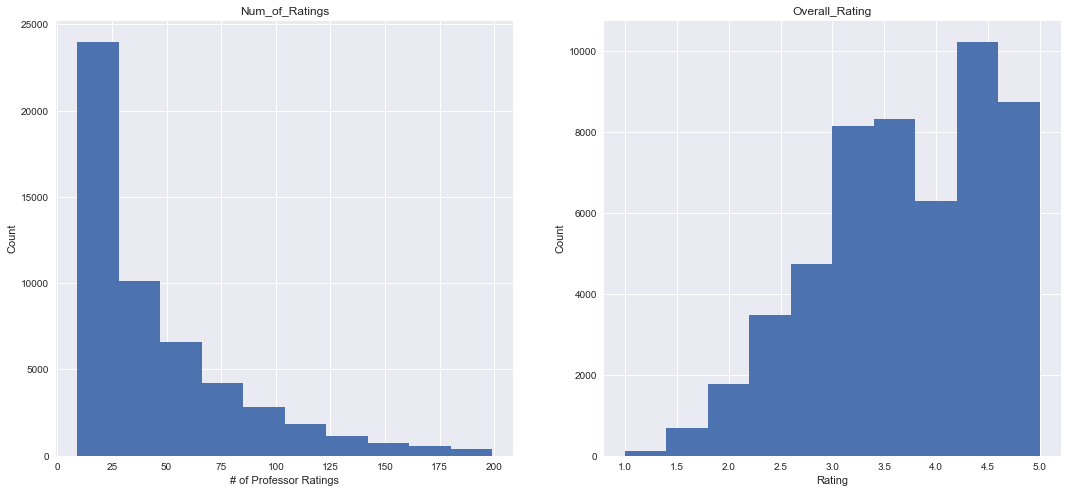

In [53]:
# Num of Ratings Overall Rating distributions

dist1 = RMP_Outlier_df["Num_of_Ratings"]
dist2 = RMP_Outlier_df["Overall_Rating"]

plt.figure(figsize=(18,8))

plt.subplot(1, 2, 1)
plt.hist(dist1)
plt.title('Num_of_Ratings')
plt.xlabel("# of Professor Ratings")
plt.ylabel("Count");

plt.subplot(1, 2, 2)
plt.hist(dist2)
plt.title('Overall_Rating')
plt.xlabel("Rating")
plt.ylabel("Count");

plt.show()

# Notice Overall_Rating my target variable has a bimodal distribution!
# Likely indicates linear regression won't be the most accurate at predicting this target

In [54]:
RMP_Outlier_df.describe()

,Num_of_Ratings,Overall_Rating,Difficulty,Hotness,TOUGH_GRADER,GIVES_GOOD_FEEDBACK,RESPECTED,GET_READY_TO_READ,PARTICIPATION_MATTERS,SKIP_CLASS_YOU_WONT_PASS,...,SO_MANY_PAPERS,CLEAR_GRADING_CRITERIA,HILARIOUS,TEST_HEAVY,GRADED_BY_FEW_THINGS,AMAZING_LECTURES,CARING,EXTRA_CREDIT,GROUP_PROJECTS,LECTURE_HEAVY
count,52486.000000,52486.000000,52486.000000,52486.000000,52486.000000,52486.000000,52486.000000,52486.000000,52486.000000,52486.000000,...,52486.000000,52486.000000,52486.000000,52486.000000,52486.000000,52486.000000,52486.000000,52486.000000,52486.000000,52486.000000
mean,44.761803,3.688827,3.084562,0.267671,2.617231,1.590977,1.774740,1.541573,1.223240,2.140571,...,0.257059,1.126091,1.430724,0.406718,0.326030,1.383283,1.451587,0.782552,0.276321,1.152155
std,37.663823,0.835568,0.752219,0.442750,5.108991,3.706975,4.023816,3.496279,2.876338,4.499262,...,0.972811,2.628761,3.872114,1.379533,1.003253,3.747891,3.326484,2.895820,1.425162,2.657255
min,9.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,3.100000,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,31.000000,3.800000,3.100000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,61.000000,4.400000,3.600000,1.000000,3.000000,2.000000,2.000000,2.000000,1.000000,2.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000
max,199.000000,5.000000,5.000000,1.000000,110.000000,97.000000,74.000000,78.000000,76.000000,102.000000,...,33.000000,76.000000,93.000000,60.000000,32.000000,98.000000,79.000000,84.000000,107.000000,50.000000


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


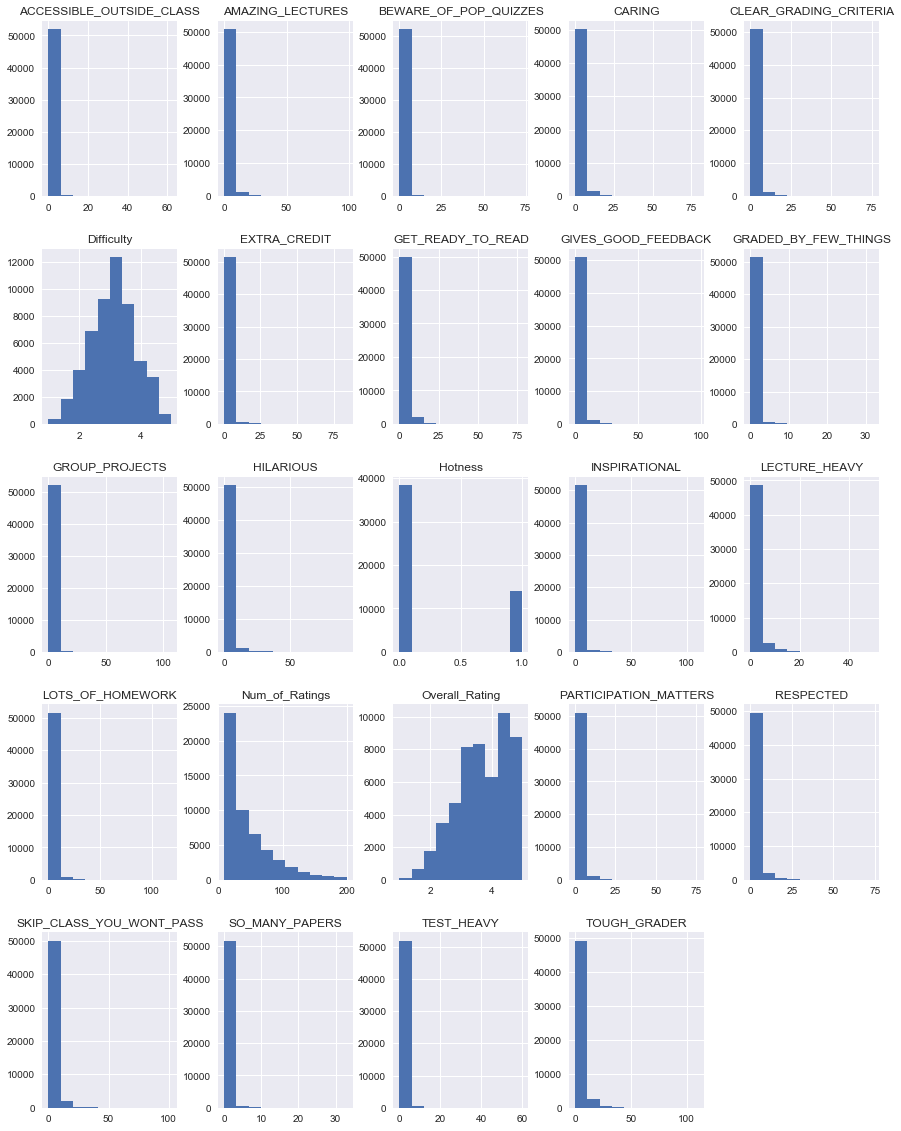

In [55]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
RMP_Outlier_df.hist(ax = ax);

In [56]:
RMP_Outlier_df.corr()["Overall_Rating"]

Num_of_Ratings             -0.038895
Overall_Rating              1.000000
Difficulty                 -0.519006
Hotness                     0.472185
TOUGH_GRADER               -0.224409
GIVES_GOOD_FEEDBACK         0.220224
RESPECTED                   0.298896
GET_READY_TO_READ          -0.088817
PARTICIPATION_MATTERS       0.074100
SKIP_CLASS_YOU_WONT_PASS   -0.044398
LOTS_OF_HOMEWORK           -0.086467
INSPIRATIONAL               0.230657
BEWARE_OF_POP_QUIZZES      -0.041387
ACCESSIBLE_OUTSIDE_CLASS    0.126004
SO_MANY_PAPERS             -0.086541
CLEAR_GRADING_CRITERIA      0.157898
HILARIOUS                   0.215123
TEST_HEAVY                 -0.093062
GRADED_BY_FEW_THINGS       -0.059113
AMAZING_LECTURES            0.251319
CARING                      0.248416
EXTRA_CREDIT                0.074345
GROUP_PROJECTS             -0.019318
LECTURE_HEAVY              -0.142381
Name: Overall_Rating, dtype: float64

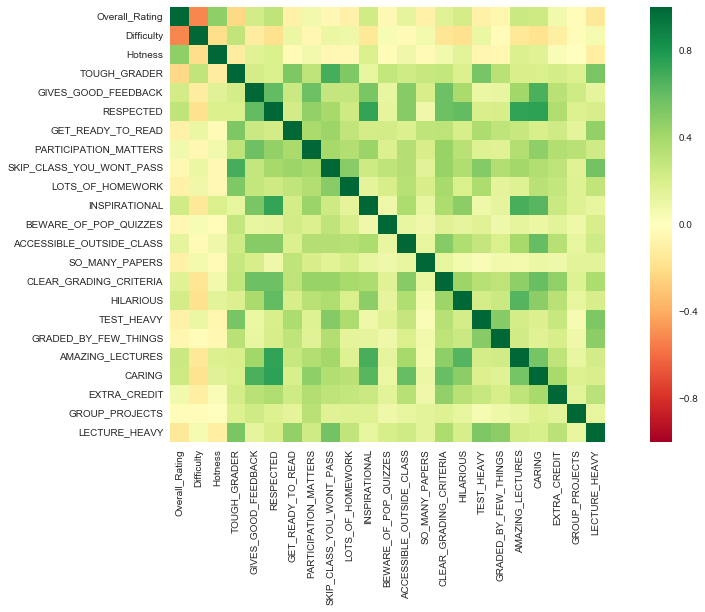

In [57]:
# Correlation Heat Map
plt.subplots(figsize=(16,8))
sns.heatmap(RMP_Outlier_df.iloc[:,1:].corr(), square=True, cmap='RdYlGn');

## 4. Baselining

* Split dataset 90/10 
* Baseline OLS model on Difficulty as the only predictor

In [58]:
# Split the data 90/10

X_train, X_test, y_train, y_test = train_test_split(RMP_Outlier_df.iloc[:,2:], RMP_Outlier_df.iloc[:,1:2], test_size=0.1, random_state=10)
X_train_full = pd.concat([y_train, X_train], axis=1)


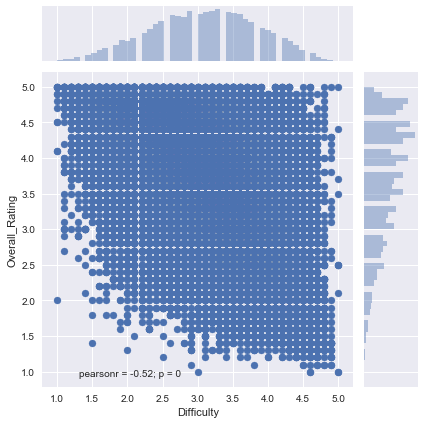

In [60]:
sns.jointplot('Difficulty', 'Overall_Rating', data=X_train_full);

In [61]:
# Baseline OLS Stats Summary

y1, X1 = patsy.dmatrices('Overall_Rating ~ Difficulty', data=X_train_full, return_type="dataframe")
model1 = sm.OLS(y1, X1)
fit1 = model1.fit()
fit1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Overall_Rating   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                 1.720e+04
Date:                Fri, 02 Feb 2018   Prob (F-statistic):               0.00
Time:                        23:50:04   Log-Likelihood:                -51208.
No. Observations:               47237   AIC:                         1.024e+05
Df Residuals:                   47235   BIC:                         1.024e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.4602      0.014    392.912      0.000       5.433       5.487
Difficulty    -0.5743      0.004   -131.163      0.000      -0.583      -0.566
==============================================================================
Omnibus:                     1065.000   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1134.670
Skew:                          -0.377   Prob(JB):                    4.07e-247
Kurtosis:                       2.909   Cond. No.                         14.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
# Baseline OLS Model Regression

rgr1 = LinearRegression()
rgr1.fit(X1,y1)
pred1 = rgr1.predict(X1)
res1 = y1 - pred1


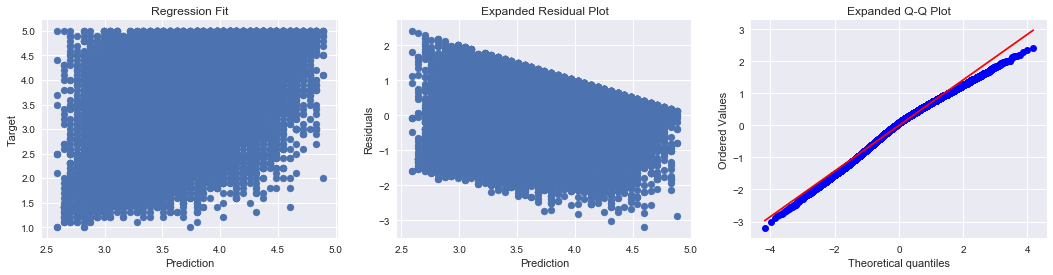

In [94]:
# Baseline OLS Model Diagnostic Plots

plt.figure(figsize=(18,4))

plt.subplot(1, 3, 1)
plt.scatter(pred1, y1)
plt.title("Regression Fit")  
plt.xlabel("Prediction")
plt.ylabel("Target");

plt.subplot(1, 3, 2)
plt.scatter(pred1, res1)
plt.title("Expanded Residual Plot")
plt.xlabel("Prediction")
plt.ylabel("Residuals");

plt.subplot(1, 3, 3)
stats.probplot(np.array(res1).reshape(-1), dist="norm", plot=plt)
plt.title("Expanded Q-Q Plot");


## 5. Expanding the Model

* Expand OLS to 7 features

In [64]:
# Expanded OLS Stats Summary

y2, X2 = patsy.dmatrices('Overall_Rating ~ Difficulty + TOUGH_GRADER + GIVES_GOOD_FEEDBACK + RESPECTED + INSPIRATIONAL + AMAZING_LECTURES + CARING', data=X_train_full, return_type="dataframe")
model2 = sm.OLS(y2, X2)
fit2 = model2.fit()
fit2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Overall_Rating   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     3421.
Date:                Fri, 02 Feb 2018   Prob (F-statistic):               0.00
Time:                        23:50:05   Log-Likelihood:                -48856.
No. Observations:               47237   AIC:                         9.773e+04
Df Residuals:                   47229   BIC:                         9.780e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.1000      0.014    357.553      0.000       5.072       5.128
Difficulty             -0.4695      0.005   -103.871      0.000      -0.478      -0.461
TOUGH_GRADER           -0.0271      0.001    -39.952      0.000      -0.028      -0.026
GIVES_GOOD_FEEDBACK     0.0209      0.001     17.623      0.000       0.019       0.023
RESPECTED               0.0327      0.002     21.335      0.000       0.030       0.036
INSPIRATIONAL          -0.0098      0.002     -6.067      0.000      -0.013      -0.007
AMAZING_LECTURES        0.0207      0.001     15.668      0.000       0.018       0.023
CARING                 -0.0013      0.002     -0.825      0.410      -0.004       0.002
==============================================================================
Omnibus:                     1293.470   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1402.625
Skew:                          -0.422   Prob(JB):                    2.65e-305
Kurtosis:                       3.017   Cond. No.                         39.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
# Expanded Model Regression

rgr2 = LinearRegression()
rgr2.fit(X2,y2)
pred2 = rgr2.predict(X2)
res2 = y2 - pred2


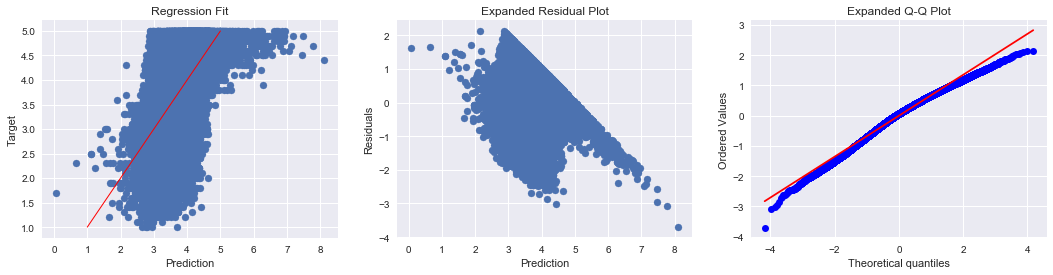

In [95]:
# Expanded Model Diagnostic Plots

plt.figure(figsize=(18,4))

plt.subplot(1, 3, 1)
plt.scatter(pred2, y2)
plt.title("Regression Fit")  
plt.plot([1,2,3,4,5], [1,2,3,4,5], color='red',linewidth=1)
plt.xlabel("Prediction")
plt.ylabel("Target");

plt.subplot(1, 3, 2)
plt.scatter(pred2, res2)
plt.title("Expanded Residual Plot")
plt.xlabel("Prediction")
plt.ylabel("Residuals");

plt.subplot(1, 3, 3)
stats.probplot(np.array(res2).reshape(-1), dist="norm", plot=plt)
plt.title("Expanded Q-Q Plot");


## 6. Complete the Model

* Full 21 feature OLS model
* Notice R-squared values improved as more features were added

In [67]:
# Full OLS Stats Summary

y3, X3 = patsy.dmatrices('Overall_Rating ~ Difficulty + TOUGH_GRADER + GIVES_GOOD_FEEDBACK + RESPECTED + GET_READY_TO_READ + PARTICIPATION_MATTERS + SKIP_CLASS_YOU_WONT_PASS + LOTS_OF_HOMEWORK + INSPIRATIONAL + BEWARE_OF_POP_QUIZZES + ACCESSIBLE_OUTSIDE_CLASS + SO_MANY_PAPERS + CLEAR_GRADING_CRITERIA + HILARIOUS + TEST_HEAVY + GRADED_BY_FEW_THINGS + AMAZING_LECTURES + CARING + EXTRA_CREDIT + GROUP_PROJECTS + LECTURE_HEAVY', data=X_train_full, return_type="dataframe")
model3 = sm.OLS(y3, X3)
fit3 = model3.fit()
fit3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Overall_Rating   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     1264.
Date:                Fri, 02 Feb 2018   Prob (F-statistic):               0.00
Time:                        23:50:07   Log-Likelihood:                -48006.
No. Observations:               47237   AIC:                         9.606e+04
Df Residuals:                   47215   BIC:                         9.625e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    5.1930      0.014    360.750      0.000       5.165       5.221
Difficulty                  -0.4920      0.005   -108.481      0.000      -0.501      -0.483
TOUGH_GRADER                -0.0131      0.001    -12.724      0.000      -0.015      -0.011
GIVES_GOOD_FEEDBACK          0.0272      0.001     20.326      0.000       0.025       0.030
RESPECTED                    0.0338      0.002     21.705      0.000       0.031       0.037
GET_READY_TO_READ            0.0017      0.001      1.477      0.140      -0.001       0.004
PARTICIPATION_MATTERS       -0.0091      0.001     -6.161      0.000      -0.012      -0.006
SKIP_CLASS_YOU_WONT_PASS     0.0108      0.001      9.705      0.000       0.009       0.013
LOTS_OF_HOMEWORK            -0.0154      0.001    -12.695      0.000      -0.018      -0.013
INSPIRATIONAL               -0.0105      0.002     -6.277      0.000      -0.014      -0.007
BEWARE_OF_POP_QUIZZES       -0.0060      0.002     -3.067      0.002      -0.010      -0.002
ACCESSIBLE_OUTSIDE_CLASS     0.0130      0.003      4.730      0.000       0.008       0.018
SO_MANY_PAPERS              -0.0348      0.003    -10.044      0.000      -0.042      -0.028
CLEAR_GRADING_CRITERIA      -0.0068      0.002     -3.793      0.000      -0.010      -0.003
HILARIOUS                    0.0013      0.001      1.199      0.230      -0.001       0.003
TEST_HEAVY                   0.0202      0.003      6.515      0.000       0.014       0.026
GRADED_BY_FEW_THINGS        -0.0517      0.004    -13.628      0.000      -0.059      -0.044
AMAZING_LECTURES             0.0206      0.001     14.284      0.000       0.018       0.023
CARING                       0.0027      0.002      1.615      0.106      -0.001       0.006
EXTRA_CREDIT                -0.0049      0.001     -3.888      0.000      -0.007      -0.002
GROUP_PROJECTS              -0.0245      0.002    -10.385      0.000      -0.029      -0.020
LECTURE_HEAVY               -0.0375      0.002    -22.767      0.000      -0.041      -0.034
==============================================================================
Omnibus:                     1568.780   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1729.129
Skew:                          -0.460   Prob(JB):                         0.00
Kurtosis:                       3.177   Cond. No.                         52.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
# Full OLS Model Regression

rgr3 = LinearRegression()
rgr3.fit(X3,y3)
pred3 = rgr3.predict(X3)
res3 = y3 - pred3


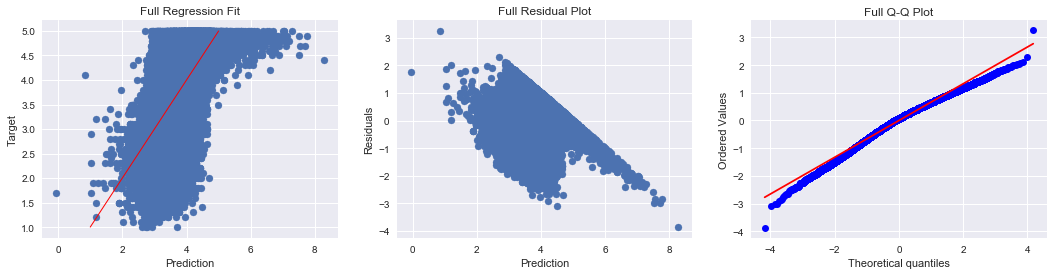

In [96]:
# Full OLS Model 3 Diagnostic Plots

plt.figure(figsize=(18,4))

plt.subplot(1, 3, 1)
plt.scatter(pred3, y3)
plt.title("Full Regression Fit")  
plt.plot([1,2,3,4,5], [1,2,3,4,5], color='red',linewidth=1)
plt.xlabel("Prediction")
plt.ylabel("Target");

plt.subplot(1, 3, 2)
plt.scatter(pred3, res3)
plt.title("Full Residual Plot")
plt.xlabel("Prediction")
plt.ylabel("Residuals");

plt.subplot(1, 3, 3)
stats.probplot(np.array(res3).reshape(-1), dist="norm", plot=plt)
plt.title("Full Q-Q Plot");


## 7.  Validate the Model

* Perform 5 fold cross validation on OLS model

In [70]:
# Splitting the X_train data into 5 Folds
kfold = KFold(n_splits=5, shuffle=True)

#### Baseline Linear Regression

In [71]:
# Baseline Linear Regression
lin_reg_est = LinearRegression()
scores = cross_val_score(lin_reg_est, X_train, y_train, cv=kfold)

print(scores)
print("Linear Reg Mean Score: ", np.mean(scores))

# Build the Model
lin_reg_est.fit(X_train, y_train)

print("\nIntercept: " + str(lin_reg_est.intercept_))
print(lin_reg_est.coef_)

[ 0.46099479  0.44863725  0.46418211  0.45763017  0.46578829]
Linear Reg Mean Score:  0.459446522447

Intercept: [ 4.87065827]
[[ -4.40311091e-01   6.29698103e-01  -1.13750982e-02   1.96601042e-02
    3.04665951e-02   1.65462692e-03  -9.62394382e-03   1.26469044e-02
   -1.31214597e-02  -1.38859186e-02  -5.73901969e-03   1.12683021e-02
   -2.79418142e-02  -3.74588293e-03  -4.34888822e-04   1.61418308e-02
   -3.93243398e-02   1.23366394e-02   2.76699407e-03  -3.37214442e-03
   -2.07920989e-02  -2.88194149e-02]]


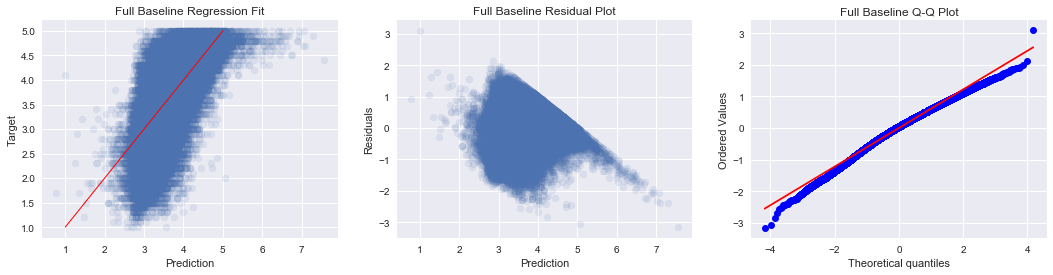

In [72]:
# Full Model Baseline Regression Subplots

y_train_pred = lin_reg_est.predict(X_train)
res = y_train - y_train_pred

plt.figure(figsize=(18,4))

plt.subplot(1, 3, 1)
plt.scatter(y_train_pred, y_train, alpha=.1)
plt.plot([1,2,3,4,5], [1,2,3,4,5], color='red',linewidth=1)
plt.title("Full Baseline Regression Fit")   
plt.xlabel("Prediction")
plt.ylabel("Target");

plt.subplot(1, 3, 2)
plt.scatter(y_train_pred, res, alpha=.1)
plt.title("Full Baseline Residual Plot")
plt.xlabel("Prediction")
plt.ylabel("Residuals");

plt.subplot(1, 3, 3)
stats.probplot(np.array(res).reshape(-1), dist="norm", plot=plt)
plt.title("Full Baseline Q-Q Plot");


## 8. Challenge & Refine Model

* Cross Validate LASSO, Ridge, Elastic Net to test benefits of regularization
* Play with LASSO to see which features get dropped as alpha is increased

In [73]:
def build_grid_search_est(model, X, y, cv=5, **params):
    
    grid_est = GridSearchCV(model, param_grid=params, cv=cv)
    grid_est.fit(X, y)
    df = pd.DataFrame(grid_est.grid_scores_)
    for param in params:
        df[param] = df.parameters.apply(lambda val: val[param])
        plt.semilogx(df.alpha, df.mean_validation_score)
        plt.xlabel("Alphas")
        plt.ylabel("R-Squared")
    grid_est.grid_scores_
    return grid_est


Lasso Grid Search


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


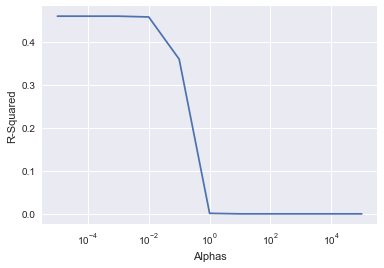

In [74]:
print("Lasso Grid Search")
lasso_grid_est = build_grid_search_est(Lasso(), X_train, y_train, cv=kfold, alpha=np.logspace(-5, 5, 11))

In [75]:
print("Lasso Grid Scores")
lasso_grid_est.grid_scores_;

Lasso Grid Scores


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [76]:
# Run LASSO using best alpha = .00001

lasso_reg_est = Lasso(alpha=.00001)
lasso_reg_est.fit(X_train, y_train)

print("\nIntercept: " + str(lasso_reg_est.intercept_))
print(lasso_reg_est.coef_)

# Notice that best alpha that yeilds the best R^2, doesn't zero out any coefficients
# R^2 = .461


Intercept: [ 4.8706036]
[ -4.40290295e-01   6.29651378e-01  -1.13751343e-02   1.96576000e-02
   3.04652230e-02   1.65108623e-03  -9.62235405e-03   1.26446630e-02
  -1.31198639e-02  -1.38805546e-02  -5.73498524e-03   1.12614699e-02
  -2.79323374e-02  -3.74011609e-03  -4.32356168e-04   1.61290871e-02
  -3.93079653e-02   1.23347427e-02   2.76616102e-03  -3.37067092e-03
  -2.07892264e-02  -2.88180971e-02]


In [77]:
# Run LASSO using best alpha = .01

lasso_reg_est2 = Lasso(alpha=.01)
lasso_reg_est2.fit(X_train, y_train)

print("\nIntercept: " + str(lasso_reg_est2.intercept_))
print(lasso_reg_est2.coef_)

# Notice that the fourth best alpha that yeilds a marginally smaller R^2, zeroes out 3 variables
# R^2 = .458


Intercept: [ 4.82073288]
[-0.42105989  0.5830799  -0.01189181  0.0175138   0.02994845 -0.
 -0.00842858  0.01067835 -0.0112624  -0.00912116 -0.00175393  0.00496926
 -0.01946636 -0.          0.          0.00326381 -0.02214042  0.01127201
  0.00222283 -0.00153554 -0.01781263 -0.02781101]


In [78]:
# Run LASSO using best alpha = .1

lasso_reg_est3 = Lasso(alpha=.1)
lasso_reg_est3.fit(X_train, y_train)

print("\nIntercept: " + str(lasso_reg_est3.intercept_))
print(lasso_reg_est3.coef_)

# Notice that the fifth best alpha that yeilds a smaller R^2, zeroes out 13 variables
# R^2 = .360


Intercept: [ 4.48911918]
[-0.27841846  0.14824646 -0.02438988  0.01259597  0.03474422 -0.         -0.
  0.         -0.00036627  0.         -0.          0.         -0.          0.
  0.00108113 -0.         -0.          0.01264669  0.         -0.         -0.
 -0.01528025]


Ridge Grid Search


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


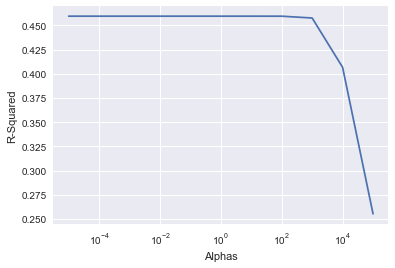

In [79]:
print("Ridge Grid Search")
ridge_grid_est = build_grid_search_est(Ridge(), X_train, y_train, cv=kfold, alpha=np.logspace(-5, 5, 11))

In [80]:
print("Ridge Grid Scores")
ridge_grid_est.grid_scores_

Ridge Grid Scores


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.45940, std: 0.00230, params: {'alpha': 1.0000000000000001e-05},
 mean: 0.45940, std: 0.00230, params: {'alpha': 0.0001},
 mean: 0.45940, std: 0.00230, params: {'alpha': 0.001},
 mean: 0.45940, std: 0.00230, params: {'alpha': 0.01},
 mean: 0.45940, std: 0.00229, params: {'alpha': 0.10000000000000001},
 mean: 0.45940, std: 0.00229, params: {'alpha': 1.0},
 mean: 0.45940, std: 0.00229, params: {'alpha': 10.0},
 mean: 0.45938, std: 0.00225, params: {'alpha': 100.0},
 mean: 0.45751, std: 0.00199, params: {'alpha': 1000.0},
 mean: 0.40663, std: 0.00250, params: {'alpha': 10000.0},
 mean: 0.25536, std: 0.00522, params: {'alpha': 100000.0}]

In [81]:
# Run Ridge using best alpha = .00001

ridge_reg_est = Ridge(alpha=.00001)
ridge_reg_est.fit(X_train, y_train)

print("\nIntercept: " + str(ridge_reg_est.intercept_))
print(ridge_reg_est.coef_)

# Notice that ridge doesn't zero out any variables, and doesn't help the R^2 at all
# R^2 = .461


Intercept: [ 4.87065827]
[[ -4.40311091e-01   6.29698103e-01  -1.13750982e-02   1.96601042e-02
    3.04665951e-02   1.65462692e-03  -9.62394382e-03   1.26469044e-02
   -1.31214597e-02  -1.38859186e-02  -5.73901968e-03   1.12683021e-02
   -2.79418142e-02  -3.74588292e-03  -4.34888815e-04   1.61418308e-02
   -3.93243398e-02   1.23366394e-02   2.76699408e-03  -3.37214442e-03
   -2.07920989e-02  -2.88194149e-02]]


In [82]:
# Run Ridge using best alpha = 100

ridge_reg_est2 = Ridge(alpha=10000)
ridge_reg_est2.fit(X_train, y_train)

print("\nIntercept: " + str(ridge_reg_est2.intercept_))
print(ridge_reg_est2.coef_)

# Notice that ridge doesn't zero out any variables, and doesn't help the R^2 at all
# R^2 = .408


Intercept: [ 4.58497563]
[[ -3.19803920e-01   3.02041448e-01  -2.04009657e-02   2.26567023e-02
    3.21554662e-02  -2.18756056e-04  -8.60222145e-03   1.06622757e-02
   -1.33923428e-02  -1.09773919e-02  -4.34740623e-03   4.78274624e-03
   -2.59729042e-02   5.25632354e-04   4.20771420e-03   1.16166259e-02
   -3.07540294e-02   1.63632083e-02   6.61723567e-03  -2.49156951e-03
   -1.97341070e-02  -3.01839366e-02]]


Elastic Net Grid Search


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


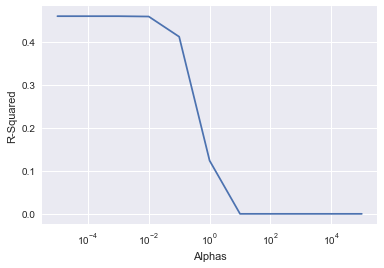

In [83]:
print("Elastic Net Grid Search")
elastic_net_grid_est = build_grid_search_est(ElasticNet(), X_train, y_train, cv=kfold, alpha=np.logspace(-5, 5, 11))

In [84]:
print("Elatic Net Grid Scores")
elastic_net_grid_est.grid_scores_

Elatic Net Grid Scores


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.45940, std: 0.00914, params: {'alpha': 1.0000000000000001e-05},
 mean: 0.45940, std: 0.00914, params: {'alpha': 0.0001},
 mean: 0.45939, std: 0.00910, params: {'alpha': 0.001},
 mean: 0.45859, std: 0.00874, params: {'alpha': 0.01},
 mean: 0.41164, std: 0.00756, params: {'alpha': 0.10000000000000001},
 mean: 0.12352, std: 0.00286, params: {'alpha': 1.0},
 mean: -0.00021, std: 0.00017, params: {'alpha': 10.0},
 mean: -0.00021, std: 0.00017, params: {'alpha': 100.0},
 mean: -0.00021, std: 0.00017, params: {'alpha': 1000.0},
 mean: -0.00021, std: 0.00017, params: {'alpha': 10000.0},
 mean: -0.00021, std: 0.00017, params: {'alpha': 100000.0}]

## 9. Test the Model

* Test the models on the test dataset
* Compare OLS prediction plots between train and test to check if overfitting occurred

In [85]:
print("Performance on Test Data:")

y_pred_t1 = lin_reg_est.predict(X_test)
print("\nLinear Regression:", r2_score(y_test, y_pred_t1))

y_pred_t2 = lasso_grid_est.predict(X_test)
print("Lasso Regression:", r2_score(y_test, y_pred_t2))

y_pred_t3 = ridge_grid_est.predict(X_test)
print("Ridge Regression:", r2_score(y_test, y_pred_t3))

y_pred_t4 = elastic_net_grid_est.predict(X_test)
print("ElasticNet Regression:", r2_score(y_test, y_pred_t4))


Performance on Test Data:

Linear Regression: 0.481836281436
Lasso Regression: 0.481836343384
Ridge Regression: 0.481837034795
ElasticNet Regression: 0.481838104338


In [86]:
# Run the full baseline regression on Test data

y_test_pred = lin_reg_est.predict(X_test)
res_test = y_test - y_test_pred


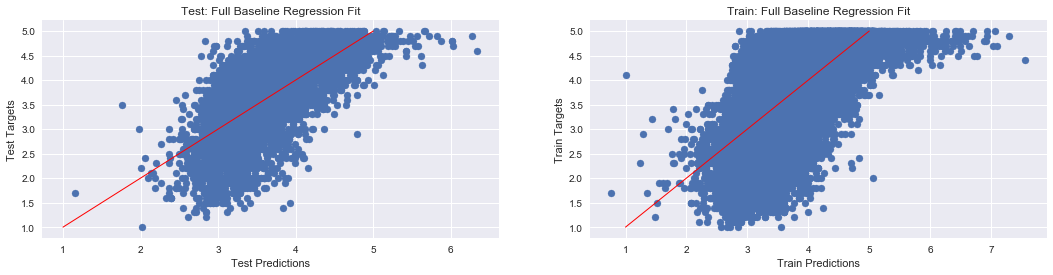

In [100]:
# Regression plots comparing train and test: Baseline OLS

plt.figure(figsize=(18,4))

plt.subplot(1, 2, 1)
plt.scatter(y_test_pred, y_test)
plt.plot([1,2,3,4,5],[1,2,3,4,5],color='red',linewidth=1) 
plt.title("Test: Full Baseline Regression Fit")   
plt.xlabel("Test Predictions")
plt.ylabel("Test Targets");

plt.subplot(1, 2, 2)
plt.scatter(y_train_pred, y_train)
plt.plot([1,2,3,4,5],[1,2,3,4,5],color='red',linewidth=1) 
plt.title("Train: Full Baseline Regression Fit")   
plt.xlabel("Train Predictions")
plt.ylabel("Train Targets");

# Plots look relatively similar, indicates no overfitting!

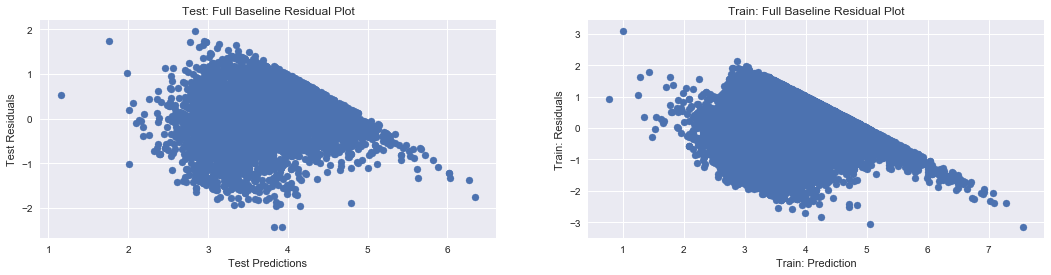

In [88]:
# Residual plots comparing train and test: Baseline OLS

plt.figure(figsize=(18,4))

plt.subplot(1, 2, 1)
plt.scatter(y_test_pred, res_test)
plt.title("Test: Full Baseline Residual Plot")
plt.xlabel("Test Predictions")
plt.ylabel("Test Residuals");

plt.subplot(1, 2, 2)
plt.scatter(y_train_pred, res)
plt.title("Train: Full Baseline Residual Plot")
plt.xlabel("Train: Prediction")
plt.ylabel("Train: Residuals");


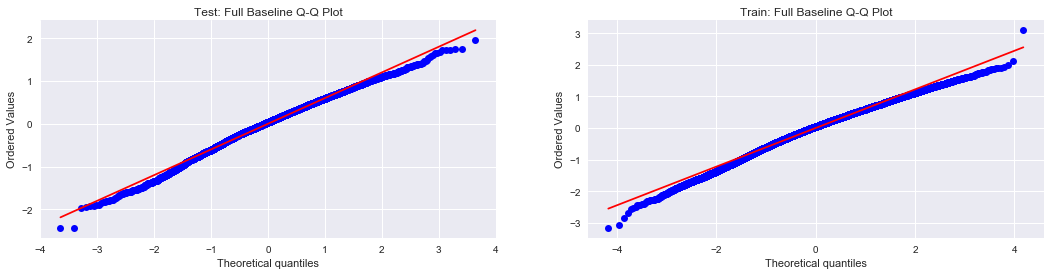

In [89]:
# QQ plots comparing train and test: Baseline OLS


plt.figure(figsize=(18,4))

plt.subplot(1, 2, 1)
stats.probplot(np.array(res_test).reshape(-1), dist="norm", plot=plt)
plt.title("Test: Full Baseline Q-Q Plot");

plt.subplot(1, 2, 2)
stats.probplot(np.array(res).reshape(-1), dist="norm", plot=plt)
plt.title("Train: Full Baseline Q-Q Plot");
